Import Packages

Data Processing


In [ ]:
# Importing necessary libraries
import pandas as pd                  # Pandas for data manipulation
import numpy as np                   # Numpy for numerical operations
from matplotlib import pyplot as plt # Matplotlib for data visualization

# Importing modules for Regression Tree Model
from sklearn.tree import DecisionTreeRegressor

# Importing modules for Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# Package to implement AdaBoost
import sklearn
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

# Importing modules for Grid Search Cross Validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Importing modules for confusion matrix and classification report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Importing module for recording time
import time
from sklearn.feature_selection import RFE

# Importing module for data pretty printer
from pprint import pprint

# Importing module to visualize Decision Tree
from sklearn import tree

# Displaying Matplotlib plots inline in the Jupyter Notebook
%matplotlib inline


# DataCleaning

In [ ]:
# Importing data from CSV files
games = pd.read_csv('games.csv')  # Reading game data
teams = pd.read_csv('teams.csv')  # Reading team data

# Removing the 'GAME_STATUS_TEXT' column from the 'games' dataframe
games.drop(columns='GAME_STATUS_TEXT', inplace=True)

# Creating separate DataFrames for home teams and away teams with team names and IDs
team_id = list(teams['TEAM_ID'])
team_name = list(teams['ABBREVIATION'])
hometeamsdf = pd.DataFrame({'HOME_TEAM_ID': team_id, 'HOME_TEAM': team_name})
awayteamsdf = pd.DataFrame({'VISITOR_TEAM_ID': team_id, 'VISITOR_TEAM': team_name})

# Merging the 'games' dataframe with the home and away team DataFrames based on team IDs
games_merge = pd.merge(pd.merge(games, hometeamsdf, on='HOME_TEAM_ID'), awayteamsdf, on='VISITOR_TEAM_ID')

# Filtering out rows where the home team's points ('PTS_home') is greater than 0
games_merge = games_merge[games_merge['PTS_home'] > 0]

# Assigning a binary variable 'home' with value 1 to indicate home games
games_merge['home'] = 1

# Dropping unnecessary columns from the merged dataframe
games_merge.drop(columns=['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID_home', 'TEAM_ID_away'], inplace=True)

# Sorting the dataframe by game date and resetting the index
games_merge.sort_values(by='GAME_DATE_EST', inplace=True)
games_merge.reset_index(inplace=True)
games_merge.drop(columns='index', inplace=True)

display(games_merge.head(5))

,GAME_DATE_EST,GAME_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_TEAM,VISITOR_TEAM,home
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,UTA,DAL,1
1,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,MEM,MIL,1
2,2003-10-07,10300004,2003,99.0,0.488,0.667,0.167,20.0,52.0,89.0,0.408,0.727,0.350,15.0,34.0,1,DAL,ORL,1
3,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,0.494,0.690,0.667,25.0,52.0,0,DET,CLE,1
4,2003-10-07,10300005,2003,104.0,0.527,0.657,0.429,22.0,33.0,80.0,0.470,0.667,0.333,10.0,37.0,1,POR,HOU,1


In [ ]:
#Duplicating each row but switching stats to create Team vs opp instead of home vs away
#Ex: Row 1 = UTA vs DAL
#Now: Row 2 = DAL vs UTA

# Creating a copy of the original dataframe
games = games_merge
games_append_away = games.copy()

# Changing the 'home' column to 0 for the away team dataframe
games_append_away['home'] = 0

# Renaming columns to switch home stats with away stats
games_append_away.columns = ['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'PTS_away', 'FG_PCT_away',
                              'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
                              'FG3_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS', 'VISITOR_TEAM', 'HOME_TEAM', 'home']

# Concatenating the original and modified dataframes to capture both perspectives
games_both = pd.concat([games, games_append_away])

# Sorting the combined dataframe by date and game ID and resetting the index
games_both.sort_values(by=['GAME_DATE_EST', 'GAME_ID'], inplace=True)
games_both.reset_index(inplace=True, drop=True)

# Renaming columns to reflect a "Team vs Opponent" perspective
games_both.rename(columns={'PTS_home': 'PTS', 'FG_PCT_home': 'FG_PCT', 'FT_PCT_home': 'FT_PCT', 'FG3_PCT_home': 'FG3_PCT',
                           'AST_home': 'AST', 'REB_home': 'REB', 'PTS_away': 'PTS_opp', 'FG_PCT_away': 'FG_PCT_opp',
                           'FT_PCT_away': 'FT_PCT_opp', 'FG3_PCT_away': 'FG3_PCT_opp', 'AST_away': 'AST_opp',
                           'REB_away': 'REB_opp', 'HOME_TEAM_WINS': 'WIN', 'HOME_TEAM': 'TEAM', 'VISITOR_TEAM': 'TEAM_opp'},
                  inplace=True)

# Recreating the logic for the 'WIN' column (1 for win, 0 for loss)
games_both['WIN'] = (games_both['PTS'] > games_both['PTS_opp']).astype(int)

# Creating a new column for point differential of each game (+ for win, - for loss)
games_both['diff'] = (games_both['PTS'] - games_both['PTS_opp']).astype(int)


display(games_both.head(5))

,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,FG_PCT_opp,FT_PCT_opp,FG3_PCT_opp,AST_opp,REB_opp,WIN,TEAM,TEAM_opp,home,diff
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,UTA,DAL,1,5
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,0.457,0.735,0.143,23.0,41.0,0,DAL,UTA,0,-5
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,MEM,MIL,1,11
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,0.494,0.618,0.267,25.0,48.0,0,MIL,MEM,0,-11
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,0.494,0.690,0.667,25.0,52.0,0,DET,CLE,1,-4


In [ ]:
# Function to add the target variable 'TARGET_WIN' representing the result of the next game (Win = 1, Loss = 0)
def add_target_win(team):
    team['TARGET_WIN'] = team['WIN'].shift(-1)
    return team

# Function to add the target variable 'TARGET_diff' representing the point differential of the next game
def add_target_diff(team):
    team['TARGET_diff'] = team['diff'].shift(-1)
    return team

# Applying the 'add_target_diff' function to calculate the point differential for the next game
games_both = games_both.groupby('TEAM', group_keys=False).apply(add_target_diff)

# Applying the 'add_target_win' function to calculate the result of the next game
games_both = games_both.groupby('TEAM', group_keys=False).apply(add_target_win)

# Handling missing values in the 'TARGET_WIN' column by assigning a value of 2
games_both['TARGET_WIN'][pd.isnull(games_both['TARGET_WIN'])] = 2


games_both

<ipython-input-4-24d98a816b24>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_both['TARGET_WIN'][pd.isnull(games_both['TARGET_WIN'])] = 2


,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,...,FG3_PCT_opp,AST_opp,REB_opp,WIN,TEAM,TEAM_opp,home,diff,TARGET_diff,TARGET_WIN
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,...,0.250,20.0,38.0,1,UTA,DAL,1,5,7.0,1.0
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,...,0.143,23.0,41.0,0,DAL,UTA,0,-5,10.0,1.0
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,...,0.154,20.0,43.0,1,MEM,MIL,1,11,-2.0,0.0
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,...,0.267,25.0,48.0,0,MIL,MEM,0,-11,-6.0,0.0
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,...,0.667,25.0,52.0,0,DET,CLE,1,-4,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,2022-12-21,22200476,2022,105.0,0.402,0.759,0.290,25.0,40.0,126.0,...,0.469,29.0,48.0,0,CHA,LAC,0,-21,NaN,2.0
53100,2022-12-22,22200477,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,...,0.321,23.0,44.0,1,NOP,SAS,1,9,NaN,2.0
53101,2022-12-22,22200477,2022,117.0,0.478,0.815,0.321,23.0,44.0,126.0,...,0.382,25.0,46.0,0,SAS,NOP,0,-9,NaN,2.0
53102,2022-12-22,22200478,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,...,0.333,20.0,37.0,1,UTA,WAS,1,8,NaN,2.0


checking if the dataset is balanced/imbalanced with respect to
the target variable

In [ ]:
games_both['TARGET_WIN'].value_counts()

0.0    26539
1.0    26535
2.0       30
Name: TARGET_WIN, dtype: int64

In [ ]:
# Function to calculate rolling averages for the last 15 games' statistics
def find_team_averages(team):
    rolling = team.rolling(10).mean()
    return rolling

# Applying the rolling average function to the dataframe grouped by 'TEAM' and 'SEASON'
df_rolling_avg = games_both.groupby(['TEAM', 'SEASON'], group_keys=False).apply(find_team_averages)

# Displaying the dataframe with rolling averages
display(df_rolling_avg)


df_rolling_avg.columns

<ipython-input-6-39611bbe7ab9>:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['GAME_DATE_EST', 'TEAM', 'TEAM_opp'], dtype='object')
  rolling = team.rolling(10).mean()


,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,FG_PCT_opp,FT_PCT_opp,FG3_PCT_opp,AST_opp,REB_opp,WIN,home,diff,TARGET_diff,TARGET_WIN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,22200405.9,2022.0,112.9,0.4409,0.7595,0.3187,23.0,46.2,122.8,0.5019,0.7568,0.4175,27.8,46.0,0.1,0.5,-9.9,NaN,0.3
53100,22200404.3,2022.0,118.7,0.4857,0.7964,0.3418,26.4,44.4,116.0,0.4687,0.7500,0.3453,25.8,43.9,0.6,0.6,2.7,NaN,0.7
53101,22200395.6,2022.0,110.4,0.4762,0.7502,0.3343,25.1,43.1,117.0,0.4913,0.7790,0.3484,24.9,43.5,0.4,0.6,-6.6,NaN,0.6
53102,22200416.4,2022.0,114.8,0.4645,0.7415,0.3679,22.9,41.6,116.9,0.5107,0.7736,0.3733,24.8,44.5,0.5,0.6,-2.1,NaN,0.7


Index(['GAME_ID', 'SEASON', 'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB',
       'PTS_opp', 'FG_PCT_opp', 'FT_PCT_opp', 'FG3_PCT_opp', 'AST_opp',
       'REB_opp', 'WIN', 'home', 'diff', 'TARGET_diff', 'TARGET_WIN'],
      dtype='object')

In [ ]:
# Creating a list of column names with "_10" added to the end, signifying last 10 game averages
rolling_columns = [f"{column}_10" for column in df_rolling_avg.columns]

# Renaming columns in df_rolling_avg with the new column names
df_rolling_avg.columns = rolling_columns

# Concatenating the original dataframe (games_both) and the dataframe with rolling averages (df_rolling_avg)
df = pd.concat([games_both, df_rolling_avg], axis=1)


df

,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,...,FG_PCT_opp_10,FT_PCT_opp_10,FG3_PCT_opp_10,AST_opp_10,REB_opp_10,WIN_10,home_10,diff_10,TARGET_diff_10,TARGET_WIN_10
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,2022-12-21,22200476,2022,105.0,0.402,0.759,0.290,25.0,40.0,126.0,...,0.5019,0.7568,0.4175,27.8,46.0,0.1,0.5,-9.9,NaN,0.3
53100,2022-12-22,22200477,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,...,0.4687,0.7500,0.3453,25.8,43.9,0.6,0.6,2.7,NaN,0.7
53101,2022-12-22,22200477,2022,117.0,0.478,0.815,0.321,23.0,44.0,126.0,...,0.4913,0.7790,0.3484,24.9,43.5,0.4,0.6,-6.6,NaN,0.6
53102,2022-12-22,22200478,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,...,0.5107,0.7736,0.3733,24.8,44.5,0.5,0.6,-2.1,NaN,0.7


In [ ]:
df = df.dropna()
df.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'PTS', 'FG_PCT', 'FT_PCT',
       'FG3_PCT', 'AST', 'REB', 'PTS_opp', 'FG_PCT_opp', 'FT_PCT_opp',
       'FG3_PCT_opp', 'AST_opp', 'REB_opp', 'WIN', 'TEAM', 'TEAM_opp', 'home',
       'diff', 'TARGET_diff', 'TARGET_WIN', 'GAME_ID_10', 'SEASON_10',
       'PTS_10', 'FG_PCT_10', 'FT_PCT_10', 'FG3_PCT_10', 'AST_10', 'REB_10',
       'PTS_opp_10', 'FG_PCT_opp_10', 'FT_PCT_opp_10', 'FG3_PCT_opp_10',
       'AST_opp_10', 'REB_opp_10', 'WIN_10', 'home_10', 'diff_10',
       'TARGET_diff_10', 'TARGET_WIN_10'],
      dtype='object')

In [ ]:
# Function to get the next value for a specific column for each team
def next_game_info(team, column_name):
    next_column = team[column_name].shift(-1)
    return next_column

# Function to apply the next_game_info function for a specific column to the entire dataframe
def add_next_game_info(df, column_name):
    return df.groupby('TEAM', group_keys=False).apply(lambda x: next_game_info(x, column_name))

# Applying the add_next_game_info function to create new columns for the next game information
df['home_next'] = add_next_game_info(df, 'home')          # Binary variable indicating if the next game is at home
df['team_opp_next'] = add_next_game_info(df, 'TEAM_opp')   # Name of the next opponent
df['game_date_next'] = add_next_game_info(df, 'GAME_DATE_EST')  # Date of the next game

<ipython-input-9-df105c924a91>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['home_next'] = add_next_game_info(df, 'home')          # Binary variable indicating if the next game is at home
<ipython-input-9-df105c924a91>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['team_opp_next'] = add_next_game_info(df, 'TEAM_opp')   # Name of the next opponent
<ipython-input-9-df105c924a91>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
# Merging data of opponent's last 10 games with the original dataframe
final = df.merge(df[rolling_columns + ['team_opp_next', 'TEAM', 'game_date_next']],
                 left_on=['TEAM', 'game_date_next'],
                 right_on=['team_opp_next', 'game_date_next'])

# Displaying the columns of the merged dataframe
final.columns

# Displaying specific columns from the merged dataframe
final[['TEAM_x', 'TEAM_y', 'home_next']]

,TEAM_x,TEAM_y,home_next
0,ATL,BKN,1.0
1,BOS,NYK,0.0
2,CLE,PHI,1.0
3,BKN,ATL,0.0
4,WAS,SAS,1.0
...,...,...,...
47371,GSW,NYK,0.0
47372,MIN,DAL,1.0
47373,CHA,SAC,0.0
47374,LAL,PHX,0.0


SPLITTING DATA AND DEVELOPING TRAINING AND TESTING SETS

In [ ]:
predictors = ['PTS_10_x', 'FG_PCT_10_x', 'FT_PCT_10_x', 'FG3_PCT_10_x',
       'AST_10_x', 'REB_10_x', 'PTS_opp_10_x', 'FG_PCT_opp_10_x',
       'FT_PCT_opp_10_x', 'FG3_PCT_opp_10_x', 'AST_opp_10_x', 'REB_opp_10_x',
       'WIN_10_x', 'home_10_x', 'diff_10_x', 'home_next','PTS_10_y', 'FG_PCT_10_y', 'FT_PCT_10_y',
       'FG3_PCT_10_y', 'AST_10_y', 'REB_10_y', 'PTS_opp_10_y',
       'FG_PCT_opp_10_y', 'FT_PCT_opp_10_y', 'FG3_PCT_opp_10_y',
       'AST_opp_10_y', 'REB_opp_10_y', 'WIN_10_y', 'home_10_y', 'diff_10_y']

train_x = final[final['SEASON'] < 2018][predictors]
test_x = final[final['SEASON'] >= 2018][predictors]

train_y = final[final['SEASON'] < 2018]['TARGET_WIN']
test_y = final[final['SEASON'] >= 2018]['TARGET_WIN']

In [ ]:
# hyper_params = [{'n_features_to_select': list(range(1, 15))}]

# folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# classifier = AdaBoostClassifier()
# rfe = RFE(classifier)

# model_cv = GridSearchCV(estimator = rfe,
#                        param_grid = hyper_params,
#                       scoring= 'f1_weighted',
#                          cv = folds,
#                          return_train_score = True,
#                          n_jobs = -1)

In [ ]:
# # Fit the model
# start = time.time()            # Start Time
# model_cv.fit(train_x, train_y)
# stop = time.time()             # End Time
# print(f"Training time: {stop - start}s")

In [ ]:
# # # Return set of parameters with the best performance
# print(model_cv.best_params_)
# # # Return the performance metric score
# print(model_cv.best_score_)


In [ ]:
# #Finding 8 best features
# rfe = RFE(estimator = classifier, n_features_to_select = 13)

# rfe = rfe.fit(train_x, train_y)

In [ ]:
# rank = pd.DataFrame(list(zip(train_x.columns, rfe.support_, rfe.ranking_)),
#               columns = ['Feature','Whether selected', 'Rank'])

# display(rank)

# rank[rank['Whether selected'] == True]

In [ ]:
# predictors_new = ['FT_PCT_opp_10_x', 'AST_opp_10_x', 'home_10_x','diff_10_x','home_next','FT_PCT_10_y',
#               'AST_10_y','FG3_PCT_10_y', 'FG_PCT_opp_10_y',
#               'AST_opp_10_y','WIN_10_y	', 'home_10_y	','diff_10_y']

# y = final['TARGET_WIN']


# train_x = final[final['SEASON'] < 2018][predictors_new]
# test_x = final[final['SEASON'] >= 2018][predictors_new]

# train_y = final[final['SEASON'] < 2018]['TARGET_WIN']
# test_y = final[final['SEASON'] >= 2018]['TARGET_WIN']

# # Data Partitioning into train and test sets
# #train_x, test_x, train_y, test_y = train_test_split(final[predictors], y, test_size = 0.2, shuffle = True)

# Implmenting AdaBoosting

In [ ]:
# Start with an initial guess for parameters
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 500, num = 10)]

learning_rate = [x for x in np.arange(0.1, 2.1, 0.1)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate
}

pprint(random_grid)

{'learning_rate': [0.1,
                   0.2,
                   0.30000000000000004,
                   0.4,
                   0.5,
                   0.6,
                   0.7000000000000001,
                   0.8,
                   0.9,
                   1.0,
                   1.1,
                   1.2000000000000002,
                   1.3000000000000003,
                   1.4000000000000001,
                   1.5000000000000002,
                   1.6,
                   1.7000000000000002,
                   1.8000000000000003,
                   1.9000000000000001,
                   2.0],
 'n_estimators': [5, 60, 115, 170, 225, 280, 335, 390, 445, 500]}


In [ ]:
# Creating stratified folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Define your model
classifier = AdaBoostClassifier(algorithm = 'SAMME', random_state = 42)

# Call RandomizedSearchCV()
random_cv = RandomizedSearchCV(estimator = classifier,
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'f1_macro',
                              cv = folds,
                              verbose = 2,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs

In [ ]:
# Fit the model
start = time.time()            # Start Time
random_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training time: 7391.692974328995s


Initial Test

Initial score:  0.6499233881649269
Initial parameters:  {'n_estimators': 500, 'learning_rate': 0.30000000000000004}

In [ ]:
print('Initial score: ', random_cv.best_score_)
print('Initial parameters: ', random_cv.best_params_)

Initial score:  0.6499233881649269
Initial parameters:  {'n_estimators': 500, 'learning_rate': 0.30000000000000004}


In [ ]:
# Create the parameter grid based on the results of random search
param_grid = {'n_estimators': [460, 480, 500, 520, 540],
              'learning_rate': [0.25, 0.3, 0.35]
}

pprint(param_grid)

{'learning_rate': [0.25, 0.3, 0.35], 'n_estimators': [460, 480, 500, 520, 540]}


In [ ]:
# Call GridSearchCV()
grid_cv = GridSearchCV(estimator = classifier,
                        param_grid = param_grid,
                        scoring= 'f1_macro',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs

In [ ]:
# Fit the model
start = time.time()            # Start Time
grid_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Training time: 2172.9310212135315s


In [ ]:
print('Improved score: ', grid_cv.best_score_)
print('Improved parameters: ', grid_cv.best_params_)

Improved score:  0.6504067968956176
Improved parameters:  {'learning_rate': 0.25, 'n_estimators': 500}


In [ ]:
# Error of each stump
grid_cv.best_estimator_.estimator_errors_

array([0.40234732, 0.40985248, 0.40944794, 0.4243038 , 0.43637409,
       0.43280029, 0.43688784, 0.4361711 , 0.44028645, 0.45758621,
       0.45473518, 0.45587089, 0.45378175, 0.45357078, 0.47082673,
       0.46852524, 0.47344578, 0.46907664, 0.46649232, 0.46221555,
       0.46386183, 0.47342878, 0.47567694, 0.47852692, 0.46983307,
       0.47332975, 0.48618292, 0.47978763, 0.47553491, 0.4716493 ,
       0.48227145, 0.48334687, 0.47897166, 0.48687909, 0.48514625,
       0.47557407, 0.47937668, 0.49067272, 0.48760845, 0.48708478,
       0.48992304, 0.47777309, 0.4933439 , 0.48851973, 0.4921176 ,
       0.4865999 , 0.49344332, 0.49009091, 0.4929161 , 0.49046263,
       0.49146496, 0.49444456, 0.48898542, 0.49189467, 0.48070422,
       0.48992848, 0.48751276, 0.49106481, 0.49358425, 0.49058654,
       0.49000282, 0.49488213, 0.49079774, 0.49198154, 0.49246117,
       0.48814518, 0.495042  , 0.49130816, 0.48254157, 0.48635324,
       0.49045239, 0.49448755, 0.49580134, 0.4944109 , 0.49254

In [ ]:
# Stump Weightage
grid_cv.best_estimator_.estimator_weights_

array([0.09892352, 0.09114382, 0.09156201, 0.0762826 , 0.06397272,
       0.06760877, 0.06345058, 0.06417906, 0.0599999 , 0.04251597,
       0.04538909, 0.04424423, 0.04635057, 0.04656337, 0.02920645,
       0.03151644, 0.02657923, 0.03096287, 0.03355798, 0.03785662,
       0.03620129, 0.02659628, 0.02434228, 0.0214863 , 0.03020361,
       0.02669559, 0.0138206 , 0.0202234 , 0.02448464, 0.02838114,
       0.01773598, 0.01665929, 0.02104075, 0.01312392, 0.01485813,
       0.02444539, 0.02063502, 0.00932836, 0.01239409, 0.0129181 ,
       0.01007833, 0.02224157, 0.00665649, 0.01148229, 0.00788305,
       0.01340331, 0.00655706, 0.00991038, 0.00708437, 0.00953853,
       0.00853587, 0.00555567, 0.01101636, 0.00810604, 0.01930537,
       0.01007288, 0.01248984, 0.00893614, 0.00641611, 0.00941457,
       0.00999851, 0.00511805, 0.0092033 , 0.00801915, 0.0075394 ,
       0.01185705, 0.00495816, 0.00869272, 0.01746553, 0.01365015,
       0.00954877, 0.00551267, 0.00419876, 0.00558933, 0.00745

In [ ]:
# Predictions on test set
y_pred = grid_cv.predict(test_x)

# Generating Classification Report
print("Classification Report - \n",
      classification_report(test_y, y_pred))

Classification Report - 
               precision    recall  f1-score   support

         0.0       0.62      0.61      0.61      5070
         1.0       0.61      0.62      0.62      5072

    accuracy                           0.61     10142
   macro avg       0.61      0.61      0.61     10142
weighted avg       0.61      0.61      0.61     10142



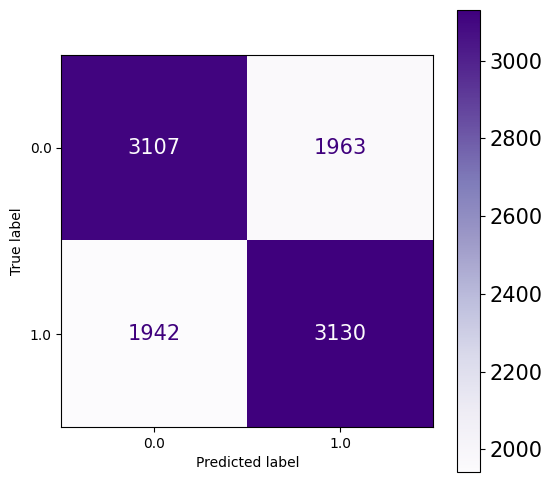

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred, labels = grid_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = grid_cv.classes_)

# Specify figure size and font size
fig, ax = plt.subplots(figsize = (6, 6))
plt.rcParams.update({'font.size': 15})

# Display Confusion Matrix
disp.plot(cmap = 'Purples', ax = ax);

In [ ]:
# Getting prediction probabilites
prob = grid_cv.predict_proba(test_x)

# Printing prediction results
result = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})

# Creating columns for rejection and acceptance prob.
result[['Prob. of 0','Prob. of 1']] = prob[1,0:2]
#pd.DataFrame(prob.tolist(), index = result.index)

# Saving dataframe as a csv file
result.to_csv('Prediction Results.csv', index = False)

result.sample(10)

,Actual,Predicted,Prob. of 0,Prob. of 1
44939,1.0,0.0,0.523181,0.476819
45433,1.0,1.0,0.523181,0.476819
40866,1.0,0.0,0.523181,0.476819
42706,1.0,1.0,0.523181,0.476819
40098,1.0,1.0,0.523181,0.476819
47096,1.0,1.0,0.523181,0.476819
37636,0.0,0.0,0.523181,0.476819
46785,1.0,1.0,0.523181,0.476819
39846,0.0,0.0,0.523181,0.476819
42320,0.0,0.0,0.523181,0.476819


In [ ]:
# Storing importance values from the best fit model
importance = grid_cv.best_estimator_.feature_importances_

In [ ]:
# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

feature_imp_df = feature_imp[feature_imp['Importance'] > 0]
display(feature_imp_df)

,Feature,Importance
0,diff_10_x,0.239135
1,diff_10_y,0.237217
2,home_next,0.135354
3,AST_10_y,0.061615
4,AST_10_x,0.060440
5,WIN_10_x,0.051397
6,WIN_10_y,0.046482
7,FG_PCT_10_y,0.034879
8,FG_PCT_10_x,0.032469
9,FG3_PCT_opp_10_x,0.019093


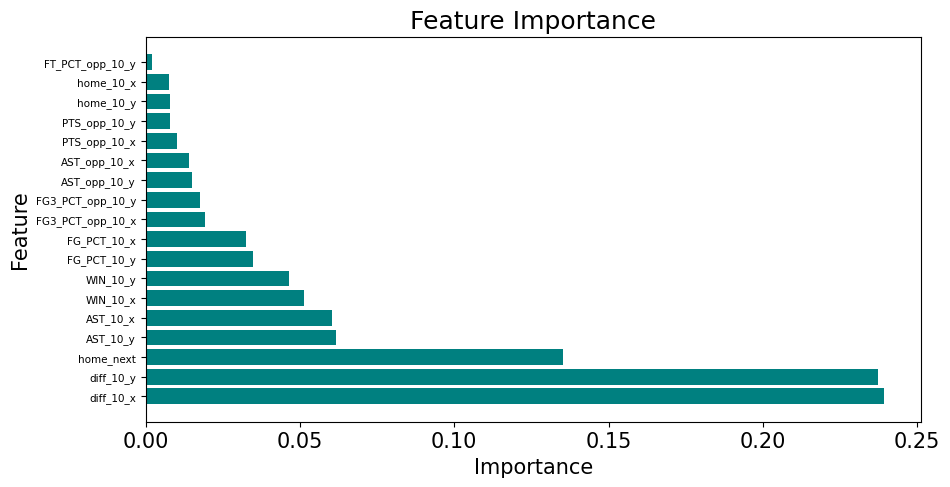

In [ ]:
# Bar plot
plt.figure(figsize=(10, 5), dpi = 100)
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color ='teal')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tick_params(axis='y', labelsize=7.5)
plt.title("Feature Importance");

In [ ]:
#2nd Run with adjusted hyperparameters
param_grid = {'n_estimators': [460, 480, 500, 520, 540],
              'learning_rate': [0.20, 0.25, 0.3]
}

model_cv = GridSearchCV(estimator = classifier,
                        param_grid = param_grid,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [ ]:
import time
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Training time: 2284.325338125229s


In [ ]:
print('2nd score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

2nd score:  0.6504068791455366
Initial parameters:  {'learning_rate': 0.25, 'n_estimators': 500}
